### LeNet-5 on MNIST

In [39]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_mnist

### Settings and Dataset

In [28]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 2
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [30]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [32]:
##########################
### MNIST DATASET
##########################

resize_transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((32, 32)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,), (0.5,))])


train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=resize_transform,
    test_transforms=resize_transform)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([256, 1, 32, 32])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 5, 8, 9, 9, 4, 9, 9, 3, 9])


### Model

In [64]:
class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()

        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 6, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
            

In [66]:
model = LeNet5(num_classes=10, grayscale=True)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max')

### Train

Epoch: 001/015 | Batch 0000/0210 | Loss: 2.3140
Epoch: 001/015 | Batch 0100/0210 | Loss: 0.5596
Epoch: 001/015 | Batch 0200/0210 | Loss: 0.2596
Epoch: 001/015 | Train: 92.56% | Validation: 94.18%
Time elapsed: 0.58 min
Epoch: 002/015 | Batch 0000/0210 | Loss: 0.2800
Epoch: 002/015 | Batch 0100/0210 | Loss: 0.2093
Epoch: 002/015 | Batch 0200/0210 | Loss: 0.1470
Epoch: 002/015 | Train: 95.68% | Validation: 96.70%
Time elapsed: 1.18 min
Epoch: 003/015 | Batch 0000/0210 | Loss: 0.1338
Epoch: 003/015 | Batch 0100/0210 | Loss: 0.1329
Epoch: 003/015 | Batch 0200/0210 | Loss: 0.1101
Epoch: 003/015 | Train: 96.82% | Validation: 97.40%
Time elapsed: 1.78 min
Epoch: 004/015 | Batch 0000/0210 | Loss: 0.0986
Epoch: 004/015 | Batch 0100/0210 | Loss: 0.1078
Epoch: 004/015 | Batch 0200/0210 | Loss: 0.0665
Epoch: 004/015 | Train: 97.50% | Validation: 97.77%
Time elapsed: 2.36 min
Epoch: 005/015 | Batch 0000/0210 | Loss: 0.0695
Epoch: 005/015 | Batch 0100/0210 | Loss: 0.0698
Epoch: 005/015 | Batch 0200/

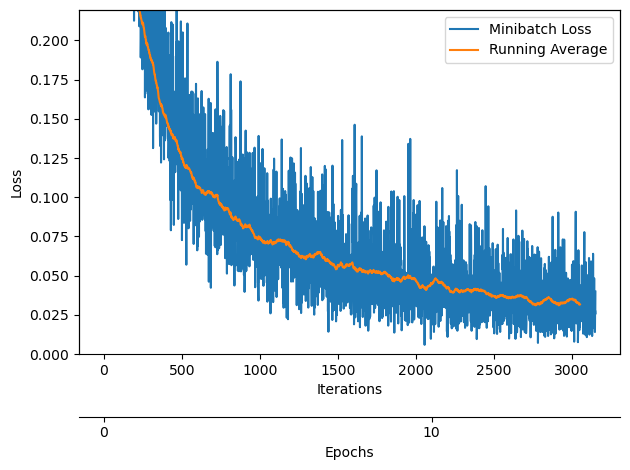

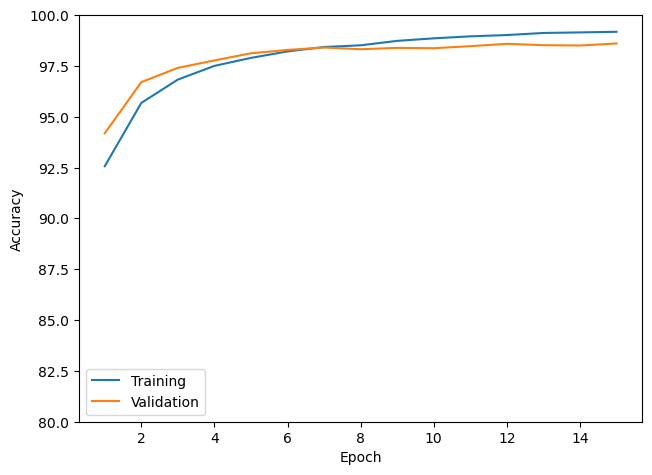

In [69]:
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=100)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

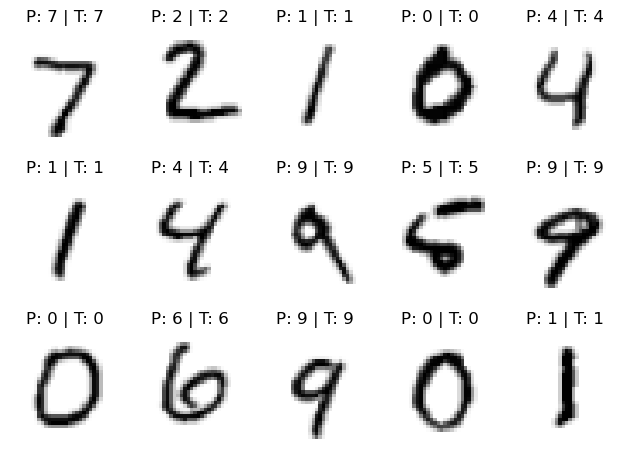

In [71]:
model.cpu()
show_examples(model=model, data_loader=test_loader)

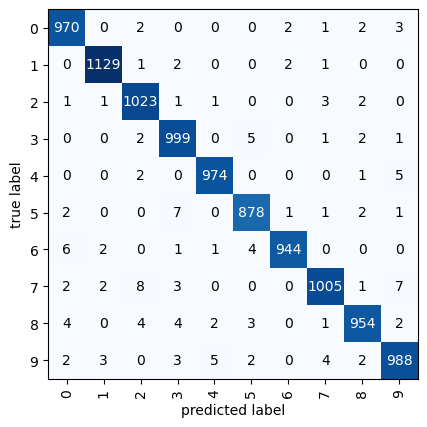

In [73]:
class_dict = {0: '0',
              1: '1',
              2: '2',
              3: '3',
              4: '4',
              5: '5',
              6: '6',
              7: '7',
              8: '8',
              9: '9'}

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()